# Work in progress.

In [54]:
import numpy as np
import pandas as pd

from bokeh.layouts import layout
from bokeh.embed import file_html

from bokeh.io import show
from bokeh.io import output_notebook

from bokeh.models import Text
from bokeh.models import Plot
from bokeh.models import Slider
from bokeh.models import Circle
from bokeh.models import Range1d
from bokeh.models import CustomJS
from bokeh.models import HoverTool
from bokeh.models import LinearAxis
from bokeh.models import ColumnDataSource
from bokeh.models import SingleIntervalTicker

from bokeh.palettes import Spectral6
pd.set_option('display.max_columns',99)
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns


In [55]:
output_notebook()

df = pd.read_csv("../data/dataset_minimal_features_for_modeling.csv")
# We are using the reduced feature dataset, but we stored it post one-hotting and 
# need the school type as a single feature to do the viz we want to do.
df_full = pd.read_csv("../data/dataset_from_ingestion.csv")


def process_data():
    # school_type 
    school_type = df_full.School_Type
    # grad_rate
    grad_rate = df.Grad_Rate
    # Turn enrollment * teacher_ratio2 into bubble sizes. Use min_size and factor to tweak.
    scale_factor = 0.8 
    min_size = 3
    # enrollment_cohort_ratio = df.Enrollment / df.All_Cohort
    
    sizing_data = np.sqrt(df['Enrollment Teacher_Ratio2'] / np.pi) / scale_factor
    # @Note: feature spans 0.08 to 27000
    sizing_data = sizing_data.where(
    sizing_data >= min_size).fillna(min_size)

    # Rla_Pct_Part is y
    rla_data = df['Rla_Pct_Part']
    rla_bins = np.percentile(rla_data, np.linspace(0, 100, num=4))
    rla_binned = np.digitize(rla_data, bins=rla_bins)

    # Reduced Price Lunch Teacher Ratio is color
    reduced_lunch_teacher_ratio = df['Enrollment Teacher_Ratio2'] 
    rlcr_bins = np.percentile(
        reduced_lunch_teacher_ratio, np.linspace(0, 100, num=6))
    rlcr_binned = np.digitize(reduced_lunch_teacher_ratio, bins=rlcr_bins)
   
    return school_type, grad_rate, sizing_data, pd.Series(rla_binned),  pd.Series(reduced_lunch_teacher_ratio), pd.Series(rla_bins), rlcr_bins



Loading BokehJS ...

In [56]:
school_type, grad_rate, sizing_data, rla_binned,  reduced_lunch_teacher_ratio, rla_bins, rlcr_bins = process_data()

In [57]:
pd.Series(np.digitize(reduced_lunch_teacher_ratio,bins=rlcr_bins)).value_counts()

3    16732
1    16732
2    16731
4    16731
5    16731
6        1
dtype: int64

<AxesSubplot: >

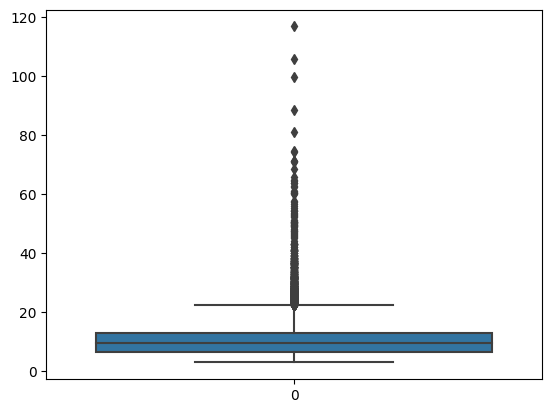

In [58]:
sns.boxplot(sizing_data)

In [59]:
print(rla_binned.value_counts()/len(rla_binned))
print(rla_bins)

3    0.422805
1    0.271929
2    0.192247
4    0.113020
dtype: float64
0     2.5
1    95.0
2    97.5
3    99.5
dtype: float64


In [60]:
sources = {}
all_bins_data = pd.concat([school_type, grad_rate,rla_binned,reduced_lunch_teacher_ratio, sizing_data],sort=True, axis=1)

In [61]:
grouped_by_school = all_bins_data.groupby('School_Type')

In [62]:
validation_df = pd.DataFrame()
for name, g in grouped_by_school:
    g.columns = 'School_Type', 'Grad_Rate', 'Rla_Binned', 'Reduced_Lunch_Teacher_Ratio', 'Sizing_Data'
    new_df = pd.DataFrame([g.median().T])
    validation_df = validation_df.append([new_df])
    sources['_' + str(name)] = ColumnDataSource(data=new_df)
#rlcr_color = pd.Series([Spectral6[bi9+65n] for bin in rlcr_binned])
validation_df


/tmp/ipykernel_541245/1405439398.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_df = validation_df.append([new_df])
/tmp/ipykernel_541245/1405439398.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_df = validation_df.append([new_df])
/tmp/ipykernel_541245/1405439398.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_df = validation_df.append([new_df])
/tmp/ipykernel_541245/1405439398.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  validation_df = validation_df.append([new_df])


,School_Type,Grad_Rate,Rla_Binned,Reduced_Lunch_Teacher_Ratio,Sizing_Data
0,1.0,90.0,3.0,204.500000,10.085135
0,2.0,25.0,1.0,157.465041,8.849617
0,3.0,92.0,3.0,194.611907,9.838294
0,4.0,47.0,1.0,17.571377,3.000000


In [63]:
import pprint
pprint.pprint(sources)

{'_1.0': ColumnDataSource(id='p1721', ...),
 '_2.0': ColumnDataSource(id='p1724', ...),
 '_3.0': ColumnDataSource(id='p1727', ...),
 '_4.0': ColumnDataSource(id='p1730', ...)}


In [64]:
school_types = [1.0,2.0, 3.0,4.0]
print(school_types)

[1.0, 2.0, 3.0, 4.0]


In [65]:
school_types = sorted(school_type.unique())
dictionary_of_sources = dict(zip([x for x in school_types], ['_%s' % x for x in school_types]))
print(dictionary_of_sources)
js_source_array = str(dictionary_of_sources).replace("'", "")

{1.0: '_1.0', 2.0: '_2.0', 3.0: '_3.0', 4.0: '_4.0'}


# Build the plot

In [66]:
# Slider is School Type
# X axis is graduation rate
# Y axis is Rla_Pct_Part

xdr = Range1d(1, 100)
ydr = Range1d(0, 5)
plot = Plot(
    x_range=xdr,
    y_range=ydr,
    outer_width=800,
    outer_height=400,
    outline_line_color=None,
    toolbar_location=None, 
    min_border=20,
)

AXIS_FORMATS = dict(
    major_label_text_font_size="10pt",
    major_label_text_font_style="normal",
    axis_label_text_font_size="10pt",

    axis_line_color='#AAAAAA',
    major_tick_line_color='#AAAAAA',
    major_label_text_color='#666666',

    major_tick_line_cap="round",
    axis_line_cap="round",
    axis_line_width=1,
    major_tick_line_width=1,
)

xaxis = LinearAxis(ticker=SingleIntervalTicker(interval=20), axis_label="Graduation Rate", **AXIS_FORMATS)
yaxis = LinearAxis(ticker=SingleIntervalTicker(interval=1), axis_label="Reading and Language Arts Test Participation", **AXIS_FORMATS)   
plot.add_layout(xaxis, 'below')
plot.add_layout(yaxis, 'left')

school_type_text = ["Regular","Unknown","Vocation", "Alternate"]


In [70]:
# Add stuff for one school type

# Background Text
text_source = ColumnDataSource({'School_Type': [school_type_text[0]]})
text = Text(x=3, y=3.5, text='School_Type', text_font_size='80pt', text_color='#EEEEEE')
plot.add_glyph(text_source, text)

# Add the circle
renderer_source = sources['_%s' % school_types[0]]
circle_glyph = Circle(
    x='Grad_Rate', y='Rla_Binned', size='Sizing_Data',
    fill_color=Spectral6[3], fill_alpha=0.7, 
    line_color='#7c7e71', line_width=0.5, line_alpha=0.5)

circle_renderer = plot.add_glyph(renderer_source, circle_glyph)

# Add hover
#tooltips = "@Rlcr_Bin"
#plot.add_tools(HoverTool(tooltips=tooltips, renderers=[circle_renderer]))

In [71]:
show(plot)

In [72]:
school_type

0        1.0
1        4.0
2        1.0
3        1.0
4        1.0
        ... 
83653    1.0
83654    1.0
83655    1.0
83656    1.0
83657    1.0
Name: School_Type, Length: 83658, dtype: float64

In [73]:
text_x = 5 
text_y = 1 
for i, region in enumerate(school_type):
    # plot.add_glyph(Text(x=text_x, y=text_y, text=[region], text_font_size='10pt', text_color='#666666'))
    plot.add_glyph(Circle(x=text_x - 0.1, y=text_y + 2, fill_color=Spectral6[i], size=10, line_color=None, fill_alpha=0.8))
    text_y = text_y - 5

IndexError: tuple index out of range